In [1]:
# Jypyter notebook specific
%matplotlib inline
from IPython.display import display, HTML

# Standard imports
import logging
import glob
import os

# Dependecy imports
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

# Load log file

In [3]:
im_paths = glob.glob('traffic_light_images/**/*.png')
im_paths += glob.glob('traffic_light_images/**/*.jpg')

labels = []

red = 0
green = 0

for path in im_paths:
    label = int(os.path.dirname(path).split('/')[-1])
    
    if label == 0 or label == 1:
        labels.append([1, 0])
        red += 1
    elif label == 2:
        labels.append([0, 1])
        green += 1

print('red', red, 'green', green)
print(len(im_paths))
print(len(labels))

('red', 961, 'green', 413)
1374
1374


# Load images

In [4]:
import cv2
import numpy as np

In [5]:
width = 400
height = 300

images = []

for path in im_paths:

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_res = cv2.resize(img, (width, height))
    
    images.append(img_res)

In [6]:
images = np.asarray(images)
print(images.shape, images.dtype)

labels = np.asarray(labels)
print(labels.shape, labels.dtype)

((1374, 300, 400, 3), dtype('uint8'))
((1374, 2), dtype('int64'))


In [7]:
images, labels = shuffle(images, labels)

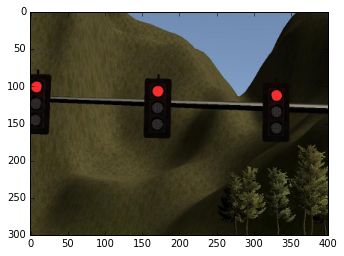

[1 0]


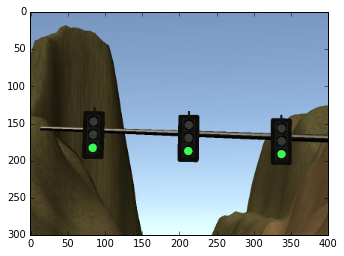

[0 1]


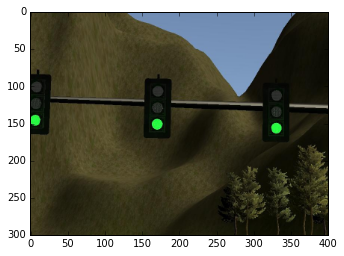

[0 1]


In [8]:
plt.imshow(images[800])
plt.show()
print(labels[800])
plt.imshow(images[500])
plt.show()
print(labels[500])
plt.imshow(images[300])
plt.show()
print(labels[300])

# Train model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
from keras.utils.data_utils import Sequence

Using TensorFlow backend.


In [10]:
activation = 'selu'
dropout = 1

def model(dshape):
    """Create keras model.

    Based on : https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
    """
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.5))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.5))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(100, activation=activation))
    # seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(2, activation='softmax'))
    seq_model.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.0001), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [11]:
keras_model = model((height, width, 3))  # creates model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 300, 400, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 198, 24)      1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 97, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 97, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 47, 48)        43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 47, 48)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 45, 64)        27712     
__________

In [12]:
keras_model.fit(images, labels, epochs=20, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 1099 samples, validate on 275 samples
Epoch 1/20
1099/1099 [==============================] - 6s - loss: 1.1802 - acc: 0.6224 - val_loss: 1.6473 - val_acc: 0.4618
Epoch 2/20
1099/1099 [==============================] - 4s - loss: 0.6784 - acc: 0.7207 - val_loss: 0.4667 - val_acc: 0.7855
Epoch 3/20
1099/1099 [==============================] - 4s - loss: 0.5026 - acc: 0.7589 - val_loss: 0.3902 - val_acc: 0.8436
Epoch 4/20
1099/1099 [==============================] - 4s - loss: 0.4623 - acc: 0.7834 - val_loss: 0.3763 - val_acc: 0.8109
Epoch 5/20
1099/1099 [==============================] - 4s - loss: 0.3913 - acc: 0.8144 - val_loss: 0.2965 - val_acc: 0.8764
Epoch 6/20
1099/1099 [==============================] - 4s - loss: 0.3823 - acc: 0.8271 - val_loss: 0.3115 - val_acc: 0.8291
Epoch 7/20
1099/1099 [==============================] - 4s - loss: 0.3135 - acc: 0.8662 - val_loss: 0.2634 - val_acc: 0.8509
Epoch 8/20
1099/1099 [==============================] - 4s - loss: 0.2650 - ac

In [13]:
def save_keras_model(save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [14]:
save_keras_model(keras_model, 'keras')

# Test model

In [15]:
from keras.models import model_from_json

In [17]:
model_path = 'kerasmodel'

In [18]:
inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [19]:
print(np.argmax(inf_model.predict(np.expand_dims(images[800], 0)), axis=1)[0])
print(np.argmax(inf_model.predict(np.expand_dims(images[500], 0)), axis=1)[0])
print(np.argmax(inf_model.predict(np.expand_dims(images[300], 0)), axis=1)[0])

0
1
1
